## LSTM with Multiple Time steps of Close Price as a Time Series Sequence

In Previous notebook, we tried different algorithms like XG Boost, Random Forest and LSTM using Extensive feature extraction where we extracted around 60 features using different Technical Indicators as well as prices of other related  Index funds like Nasdaq-100 QQQ ETF, SNP 500 Index and DJIA Index fund. Linear Regression, Random Forest and XG Boost performed really well, on an average an MAE(Mean Absolute error) of around 0.36. We also checked for Feature importance using RF. But LSTM did not perform good with these features. As expected as we did not feed any long sequence of previous data. The  Indicators for a previous day is not enough for Long short term memory. 

In this Notebook, we will focus on the Close price sequence of previous days. And we we also tune the number of lagged days to consider for prediction. With LSTM, we will try a lookback of 30 days approx 1+ months to predict the price of next day. 

### Import the Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
import numpy as np
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import cross_validate,GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
#from sklearn.feature_extraction import DictVectorizer
#from sklearn.utils.multiclass import unique_labels
# import scikitplot as skplt
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline



In [2]:
file_path = r'C:\Users\ashok\Desktop\SPPO\Streamlit Web App\META.csv'

In [3]:
Stock = pd.read_csv(file_path)
#best features
features_selected = ['Open','High', 'Low','QQQ_Close', 'SnP_Close', 'DJIA_Close', 'Close(t)']
df_Stock = Stock[features_selected]
df_Stock = df_Stock.iloc[:-100, :]
df_Stock = df_Stock.rename(columns={'Close(t)':'Close'})

df_Stock['Diff'] = df_Stock['Close'] - df_Stock['Open']
df_Stock['High-low'] = df_Stock['High'] - df_Stock['Low']

df_Stock.head()

,Open,High,Low,QQQ_Close,SnP_Close,DJIA_Close,Close,Diff,High-low
0,267.051235,268.488284,263.129302,283.289978,3483.340088,28494.199219,266.173035,-0.878200,5.358983
1,266.831682,270.813490,264.755931,281.737335,3483.810059,28606.310547,265.384644,-1.447039,6.057559
2,264.985457,267.999253,259.347050,277.137756,3426.919922,28195.419922,260.863922,-4.121535,8.652203
3,262.520550,269.146948,262.340926,277.733490,3443.120117,28308.789062,267.011322,4.490772,6.806022
4,278.986701,282.469535,275.803241,277.518707,3435.560059,28210.820312,278.158417,-0.828285,6.666294


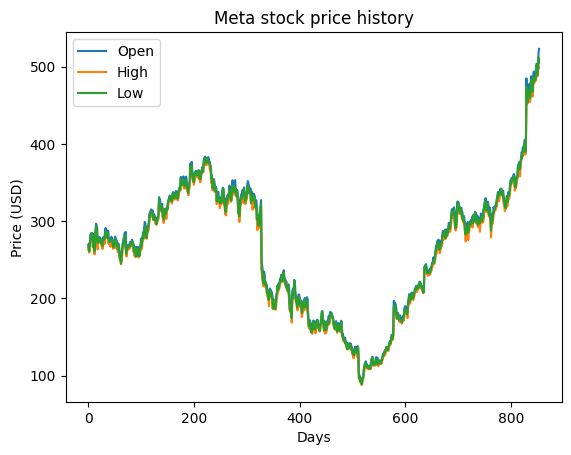

In [5]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(df_Stock["High"])
plt.plot(df_Stock["Low"])
plt.plot(df_Stock["Close"])
plt.title('Meta stock price history')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.show()

### Create Lagged Features for getting Previous day prices for a lookback of 30 days

In [6]:
def prepare_lagged_features(df_Stock, lag_stock, lag_index):

        print('Preparing Lagged Features for Stock, Index Funds.....')
        lags = range(1, lag_stock+1)
        lag_cols= ['Close']
        df_Stock=df_Stock.assign(**{
            '{}(t-{})'.format(col, l): df_Stock[col].shift(l)
            for l in lags
            for col in lag_cols
        })

       
        lags = range(1, lag_index+1)
        lag_cols= ['QQQ_Close','SnP_Close','DJIA_Close']
        df_Stock= df_Stock.assign(**{
            '{}(t-{})'.format(col, l): df_Stock[col].shift(l)
            for l in lags
            for col in lag_cols
        })

        df_Stock = df_Stock.drop(columns=lag_cols)


        remove_lags_na = max(lag_stock, lag_index) + 1
        print('Removing NAN rows - ', str(remove_lags_na))
        df_Stock = df_Stock.iloc[remove_lags_na:,]
        return df_Stock


In [7]:
df_Stock = prepare_lagged_features(df_Stock, lag_stock = 20, lag_index = 5)
df_Stock.head()

Preparing Lagged Features for Stock, Index Funds.....
Removing NAN rows -  21


,Open,High,Low,Close,Diff,High-low,Close(t-1),Close(t-2),Close(t-3),Close(t-4),...,DJIA_Close(t-2),QQQ_Close(t-3),SnP_Close(t-3),DJIA_Close(t-3),QQQ_Close(t-4),SnP_Close(t-4),DJIA_Close(t-4),QQQ_Close(t-5),SnP_Close(t-5),DJIA_Close(t-5)
21,277.150459,277.190386,272.539939,276.382050,-0.768410,4.650447,274.515869,275.913025,271.871307,278.198303,...,29397.630859,276.766815,3545.530029,29420.919922,281.815430,3550.500000,29157.970703,287.694122,3509.439941,28323.400391
22,274.485954,278.837029,274.066832,278.387939,3.901986,4.770197,276.382050,274.515869,275.913025,271.871307,...,29080.169922,282.957977,3572.659912,29397.630859,276.766815,3545.530029,29420.919922,281.815430,3550.500000,29157.970703
23,277.110532,277.110532,272.729551,274.436035,-2.674497,4.380981,278.387939,276.382050,274.515869,275.913025,...,29479.810547,281.629883,3537.010010,29080.169922,282.957977,3572.659912,29397.630859,276.766815,3545.530029,29420.919922
24,273.957020,276.821160,271.282524,271.412262,-2.544758,5.538637,274.436035,278.387939,276.382050,274.515869,...,29950.439453,284.100494,3585.149902,29479.810547,281.629883,3537.010010,29080.169922,282.957977,3572.659912,29397.630859
25,270.464204,272.909191,268.637970,272.380280,1.916076,4.271222,271.412262,274.436035,278.387939,276.382050,...,29783.349609,286.317200,3626.909912,29950.439453,284.100494,3585.149902,29479.810547,281.629883,3537.010010,29080.169922


In [8]:
df_Stock = df_Stock.drop(columns=['Open', 'High', 'Low'])

In [9]:
df_Stock= df_Stock.iloc[31:452,]
df_Stock.shape

(421, 38)

In [10]:
train=df_Stock.iloc[:340,]
test=df_Stock.iloc[340:,]

In [11]:
train.columns

Index(['Close', 'Diff', 'High-low', 'Close(t-1)', 'Close(t-2)', 'Close(t-3)',
       'Close(t-4)', 'Close(t-5)', 'Close(t-6)', 'Close(t-7)', 'Close(t-8)',
       'Close(t-9)', 'Close(t-10)', 'Close(t-11)', 'Close(t-12)',
       'Close(t-13)', 'Close(t-14)', 'Close(t-15)', 'Close(t-16)',
       'Close(t-17)', 'Close(t-18)', 'Close(t-19)', 'Close(t-20)',
       'QQQ_Close(t-1)', 'SnP_Close(t-1)', 'DJIA_Close(t-1)', 'QQQ_Close(t-2)',
       'SnP_Close(t-2)', 'DJIA_Close(t-2)', 'QQQ_Close(t-3)', 'SnP_Close(t-3)',
       'DJIA_Close(t-3)', 'QQQ_Close(t-4)', 'SnP_Close(t-4)',
       'DJIA_Close(t-4)', 'QQQ_Close(t-5)', 'SnP_Close(t-5)',
       'DJIA_Close(t-5)'],
      dtype='object')

In [12]:
Y_train= train[['Close']]
X_train=train[['Diff', 'High-low', 'Close(t-1)', 'Close(t-2)', 'Close(t-3)',
       'Close(t-4)', 'Close(t-5)', 'Close(t-6)', 'Close(t-7)', 'Close(t-8)',
       'Close(t-9)', 'Close(t-10)', 'Close(t-11)', 'Close(t-12)',
       'Close(t-13)', 'Close(t-14)', 'Close(t-15)', 'Close(t-16)',
       'Close(t-17)', 'Close(t-18)', 'Close(t-19)', 'Close(t-20)',
       'QQQ_Close(t-1)', 'SnP_Close(t-1)', 'DJIA_Close(t-1)', 'QQQ_Close(t-2)',
       'SnP_Close(t-2)', 'DJIA_Close(t-2)', 'QQQ_Close(t-3)', 'SnP_Close(t-3)',
       'DJIA_Close(t-3)', 'QQQ_Close(t-4)', 'SnP_Close(t-4)',
       'DJIA_Close(t-4)', 'QQQ_Close(t-5)', 'SnP_Close(t-5)',
       'DJIA_Close(t-5)']]



Y_test= test[['Close']]
X_test= test[['Diff', 'High-low', 'Close(t-1)', 'Close(t-2)', 'Close(t-3)',
       'Close(t-4)', 'Close(t-5)', 'Close(t-6)', 'Close(t-7)', 'Close(t-8)',
       'Close(t-9)', 'Close(t-10)', 'Close(t-11)', 'Close(t-12)',
       'Close(t-13)', 'Close(t-14)', 'Close(t-15)', 'Close(t-16)',
       'Close(t-17)', 'Close(t-18)', 'Close(t-19)', 'Close(t-20)',
       'QQQ_Close(t-1)', 'SnP_Close(t-1)', 'DJIA_Close(t-1)', 'QQQ_Close(t-2)',
       'SnP_Close(t-2)', 'DJIA_Close(t-2)', 'QQQ_Close(t-3)', 'SnP_Close(t-3)',
       'DJIA_Close(t-3)', 'QQQ_Close(t-4)', 'SnP_Close(t-4)',
       'DJIA_Close(t-4)', 'QQQ_Close(t-5)', 'SnP_Close(t-5)',
       'DJIA_Close(t-5)']]

### Scale features for LSTM Training

In [13]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(Y_train)

In [14]:
x_train, y_train = [], []
for i in range(60,len(Y_train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

### Create and fit the LSTM network

In [15]:
lstm = Sequential()
lstm.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
lstm.add(LSTM(units=50))
lstm.add(Dense(1))

lstm.compile(loss='mean_squared_error', optimizer='adam')
lstm.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
history_lstm = lstm.fit(x_train, y_train, epochs=25, batch_size=5, verbose=2)

Epoch 1/25
56/56 - 5s - 80ms/step - loss: 0.0431
Epoch 2/25
56/56 - 1s - 20ms/step - loss: 0.0081
Epoch 3/25
56/56 - 1s - 21ms/step - loss: 0.0066
Epoch 4/25
56/56 - 1s - 20ms/step - loss: 0.0057
Epoch 5/25
56/56 - 1s - 20ms/step - loss: 0.0065
Epoch 6/25
56/56 - 1s - 20ms/step - loss: 0.0060
Epoch 7/25
56/56 - 1s - 21ms/step - loss: 0.0052
Epoch 8/25
56/56 - 1s - 26ms/step - loss: 0.0046
Epoch 9/25
56/56 - 1s - 20ms/step - loss: 0.0045
Epoch 10/25
56/56 - 1s - 20ms/step - loss: 0.0068
Epoch 11/25
56/56 - 1s - 21ms/step - loss: 0.0048
Epoch 12/25
56/56 - 1s - 20ms/step - loss: 0.0042
Epoch 13/25
56/56 - 1s - 23ms/step - loss: 0.0043
Epoch 14/25
56/56 - 1s - 22ms/step - loss: 0.0042
Epoch 15/25
56/56 - 1s - 21ms/step - loss: 0.0043
Epoch 16/25
56/56 - 1s - 22ms/step - loss: 0.0038
Epoch 17/25
56/56 - 1s - 22ms/step - loss: 0.0041
Epoch 18/25
56/56 - 1s - 21ms/step - loss: 0.0039
Epoch 19/25
56/56 - 1s - 19ms/step - loss: 0.0034
Epoch 20/25
56/56 - 1s - 20ms/step - loss: 0.0037
Epoch 21/

In [17]:
history_lstm.history.keys()

dict_keys(['loss'])

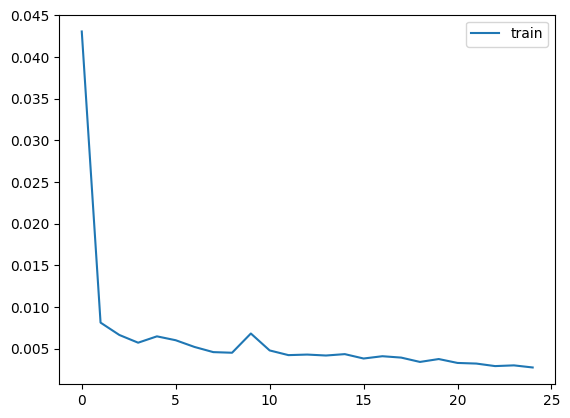

In [18]:
plt.plot(history_lstm.history['loss'], label='train')
#plt.plot(history_lstm.history['val_loss'], label='test')
plt.legend()
plt.show()

In [19]:
new_df_Stock = df_Stock['Close']

In [20]:
#predicting 246 values, using past 60 from the train data
inputs = new_df_Stock[len(new_df_Stock) - len(Y_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

In [21]:
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = lstm.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step


In [23]:
rms=np.sqrt(np.mean(np.power((Y_test-closing_price),2)))
rms

10.288336199510965

In [24]:
closing_price

array([[211.17986],
       [211.01862],
       [208.41032],
       [205.66153],
       [201.79758],
       [198.7445 ],
       [197.85231],
       [198.21954],
       [199.49318],
       [199.09277],
       [197.97487],
       [197.16162],
       [197.07117],
       [194.76186],
       [192.47098],
       [191.87009],
       [192.63194],
       [193.57672],
       [193.60344],
       [194.95625],
       [195.23526],
       [195.6192 ],
       [196.19926],
       [196.91705],
       [195.42606],
       [191.98164],
       [186.65656],
       [181.53072],
       [178.22234],
       [175.02286],
       [172.81963],
       [170.50127],
       [168.35085],
       [167.0059 ],
       [167.74855],
       [169.26553],
       [169.68375],
       [169.94049],
       [169.73073],
       [169.16978],
       [169.62753],
       [170.71086],
       [172.23186],
       [173.52274],
       [173.37576],
       [172.65094],
       [171.8282 ],
       [170.36609],
       [169.74382],
       [169.96051],


In [25]:
closing_price.shape

(81, 1)

In [26]:
Y_test

,Close
392,203.352127
393,195.807632
394,197.244675
395,188.352951
396,190.847824
...,...
468,168.433868
469,161.448242
470,158.843582
471,156.837723


In [27]:
def get_mape(y_true, y_pred): 
        """
        Compute mean absolute percentage error (MAPE)
        """
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [28]:
print('R2 - ',round(metrics.r2_score(Y_test.Close,closing_price),2))
print('MAPE - ', round(get_mape(Y_test.Close,closing_price), 2))
print('RMSE -', round(np.sqrt(metrics.mean_squared_error(Y_test.Close,closing_price)),2))
print('MAE - ', round(metrics.mean_absolute_error(Y_test.Close,closing_price),2))


R2 -  0.45
MAPE -  9.32
RMSE - 10.29
MAE -  8.28


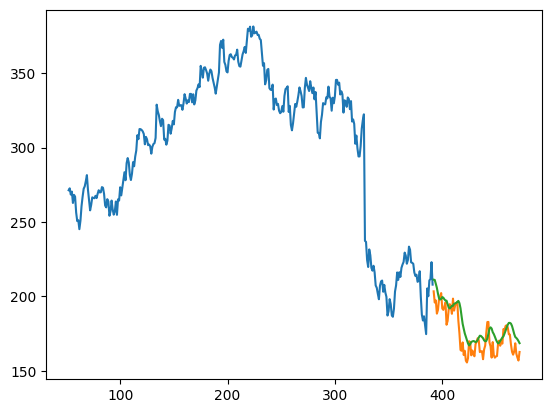

In [29]:
#for plotting
test_result=Y_test
test_result['predict']=closing_price
plt.plot(train['Close'])
plt.plot(test_result[['Close','predict']])

### Conclusion

We got Amazing results by using a 60 day lookup window for Previos Closing Prices, Index funds and by considering the difference between the High low prices.

- R2 -  0.74
- MAPE -  8.41
- RMSE - 1.81
- MAE -  1.5